In [1]:
import torch
import matplotlib.pyplot as plt
import sympy as sp

from layers import LinearLayer, SymbolicLayer

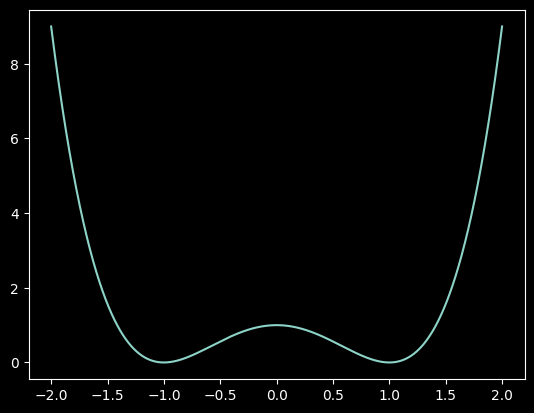

In [3]:
# Target function
def f(x): return 1 - 2 * x ** 2 + x ** 4

x = torch.linspace(-2,2,10000).reshape((-1,1))
y = f(x)
plt.plot(x, y);

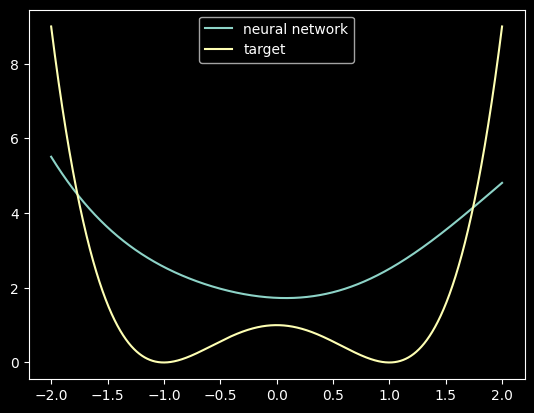

In [4]:
# Initial output of the network
layers = [LinearLayer(1, 6), SymbolicLayer(), LinearLayer(5, 6),
          SymbolicLayer(), LinearLayer(5, 1)]
y_hat = x.clone()
for layer in layers:
    y_hat = layer.forward(y_hat)
plt.plot(x, y_hat, label='neural network')
plt.plot(x, y, label='target')
plt.legend();

In [5]:
regularization = 0.1
for layer in layers:
    for p in layer.parameters():
        p.requires_grad = True


learning_rate = 0.01
batch_size = 64
iterations = 10000
for i in range(iterations):
    if i > 0.9 * iterations:
        # L0 regularization
        for layer in layers:
            for p in layer.parameters():
                with torch.no_grad():
                    p[p.abs() < 0.01] = 0.0
    ix = torch.randint(0, len(x), (batch_size,))
    x_batch = x[ix]
    y_batch = y[ix]
    with torch.no_grad():
        y_hat = x_batch.clone()
    for layer in layers:
        y_hat = layer.forward(y_hat)

    loss = ((y_hat - y_batch) ** 2).mean(0) 
    if int(0.3*iterations) < i < int(0.9*iterations):
        # L1 regularization
        loss += regularization * sum([p.abs().sum() for layer in layers for p in layer.parameters()])
    for layer in layers:
        for p in layer.parameters():
            p.grad = None
    loss.backward()
    for layer in layers:
        for p in layer.parameters():
            with torch.no_grad():
                p += -learning_rate * p.grad
    print(f'Loss: {loss.item():.3f}')


Loss: 3.653
Loss: 20.287
Loss: 58.998
Loss: 3.756
Loss: 4.370
Loss: 3.381
Loss: 2.203
Loss: 2.036
Loss: 1.963
Loss: 1.581
Loss: 1.871
Loss: 1.620
Loss: 1.496
Loss: 1.542
Loss: 1.563
Loss: 1.832
Loss: 1.339
Loss: 1.072
Loss: 1.049
Loss: 1.251
Loss: 0.984
Loss: 0.812
Loss: 1.187
Loss: 0.942
Loss: 1.130
Loss: 0.958
Loss: 0.631
Loss: 0.719
Loss: 0.808
Loss: 0.784
Loss: 0.639
Loss: 0.626
Loss: 0.472
Loss: 0.652
Loss: 0.641
Loss: 0.530
Loss: 0.538
Loss: 0.463
Loss: 0.282
Loss: 0.472
Loss: 0.338
Loss: 0.273
Loss: 0.329
Loss: 0.335
Loss: 0.310
Loss: 0.323
Loss: 0.388
Loss: 0.264
Loss: 0.253
Loss: 0.137
Loss: 0.180
Loss: 0.141
Loss: 0.183
Loss: 0.142
Loss: 0.085
Loss: 0.149
Loss: 0.087
Loss: 0.085
Loss: 0.108
Loss: 0.102
Loss: 0.085
Loss: 0.067
Loss: 0.068
Loss: 0.047
Loss: 0.075
Loss: 0.142
Loss: 0.193
Loss: 0.100
Loss: 0.114
Loss: 0.257
Loss: 1.512
Loss: 1.030
Loss: 1.139
Loss: 0.075
Loss: 0.060
Loss: 0.048
Loss: 0.033
Loss: 0.037
Loss: 0.039
Loss: 0.034
Loss: 0.048
Loss: 0.244
Loss: 0.743
Lo

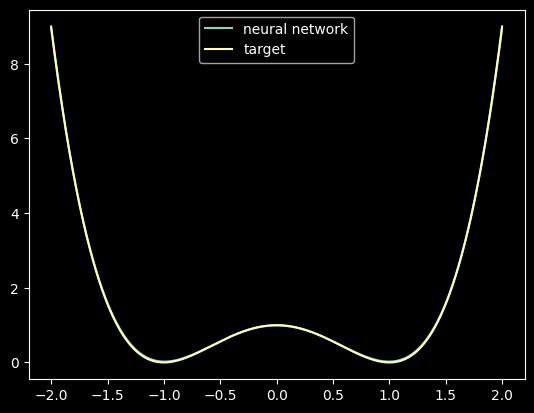

In [6]:
y_hat = x.clone()
for layer in layers:
    y_hat = layer.forward(y_hat)
plt.plot(x, y_hat.detach(), label='neural network')
plt.plot(x, y, label='target')
plt.legend();


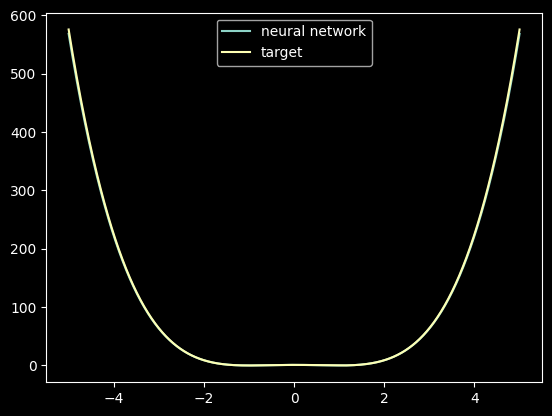

In [7]:
x2 = torch.linspace(-5,5,1000).reshape((-1, 1))
y2 = x2.clone()
for layer in layers:
    y2 = layer.forward(y2)
plt.plot(x2, y2.detach(), label='neural network')
plt.plot(x2, f(x2), label='target')
plt.legend();


In [8]:
# Symbolic pass through the network to obtain the resulting symoblic expression
for layer in layers:
    for p in layer.parameters():
        p.requires_grad = False
q = sp.Symbol('x')
for layer in layers:
    q = layer.sp_forward(q)
q

Matrix([[0.728004*(-0.768875*(1.23345 - 1.23865*x)*(1.22217*x + 1.21641) - 5.39499e-5)*(-0.768834*(1.23345 - 1.23865*x)*(1.22217*x + 1.21641) - 5.39528e-5) + 0.0236499]])

In [9]:
q.simplify()
sp.expand(q)

Matrix([[0.986237*x**4 - 0.00102282*x**3 - 1.95504*x**2 + 0.00101377*x + 0.992526]])

<lambdifygenerated-1>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array([[0.986237*x**4 - 0.00102282*x**3 - 1.95504*x**2 + 0.00101377*x + 0.992526]])


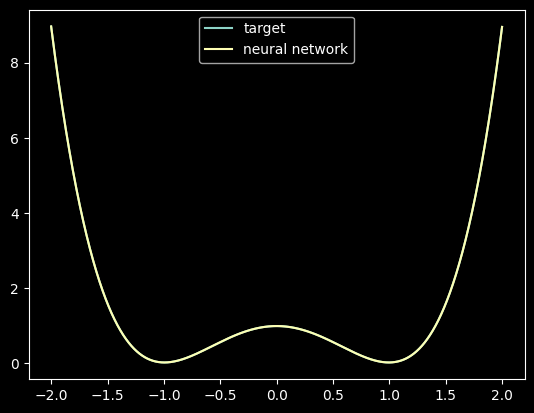

In [10]:
f_hat = sp.lambdify('x', q)
y = []
for val in x:
    y.append(f_hat(val)[0][0])
y_hat = x.clone()
for layer in layers:
    y_hat = layer.forward(y_hat)
plt.plot(x, y, label='target')
plt.plot(x, y_hat.detach(), label='neural network')
plt.legend();